# Probability of success transmission of LoRa messages

For given period of time (*n* seconds) return probability of successful transimission of LoRa uplink message. 

Probability should rise up as time period gets bigger (*n*  is bigger). 
$$ n = 0 \Rightarrow p_{st} = 0 $$ 

$$ n \in <0, +\infty> \Rightarrow p_{st} \in <0, 1> $$

$$ n = \infty \Rightarrow p_{st} = 1 $$

Estimation of successfully transmitted messages will be inferenced from LSTM output but function evaluation will be performed on measured data from real deployment. Data is structured as time series sequence of 1s and 0s which represents device activity. Resolution of time is on scale of seconds. Since the data is measured for the long period of time (more than few months), only partial data will be considered.

In [3]:
import pandas as pd
import os

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
PROCESSED_PATH = 'data/processed'

df = pd.read_csv(os.path.join(PROJ_ROOT, PROCESSED_PATH, 'single_device_activation.csv'),
                header=0, sep=',')

Function will take 3 parameters:
- data - original dataset structured as described above
- sample - if the partial data taken as argument above is considered as population this will be finite sample of the population
- window - number that represents number of elements of sliding window which will go through all of the sampled datam

In [2]:
df[:2000000].Active.value_counts()

0.0    1981627
1.0      18373
Name: Active, dtype: int64

In [3]:
data_test = df[:5000000].copy()

In [1]:
import matplotlib.pyplot as plt
from itertools import islice
import numpy as np

def gen_window(seq, n):
    """Returns a sliding window (of width n) over data from the iterable"""
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def estimate_prob(data, window_size):
    """Returns a probability estimate for given data sample in 
       n=window_size number of seconds"""
    windows = gen_window(data, n=window_size)

    window_prob = []

    for window in windows:
        ones_freq = 0
        for data_point in window:
            if data_point == 1:
                ones_freq += 1
        window_prob.append(ones_freq/window_size)
    return 1 - window_prob.count(0.0)/len(window_prob)

def plot_data(data, time=range(24)):
    fig = plt.figure(facecolor='white', figsize=(12,3))
    plt.plot(time, data, 'b-.o')
    plt.show()

def plot_prob(probs, time_points):
    fig = plt.figure(facecolor='white', figsize=(12,3))
    
    plt.ylabel('est_prob')
    plt.xlabel('time [s]')
    plt.title('Estimated probability of successful transmission of messages')
    
    plt.xscale('log')
    
    plt.plot(time_points, probs)
    
    for a,b in zip(time_points, probs): 
        plt.text(a, round(b, 4), str(round(b, 4)))
    plt.show()

In [5]:
max_w_size = [1, 10, 30, 60, 600, 1800, 3600, 9000, 50000]

probs = []
for w in max_w_size:
    probs.append(estimate_prob(data_test.Active, window_size=w))

In [6]:
probs

[0.012611599999999945,
 0.12145981862767352,
 0.3334055337520958,
 0.566424283806549,
 0.8359545473547731,
 0.8406930813706772,
 0.8448813455925576,
 0.8539200853696483,
 0.903753958837584]

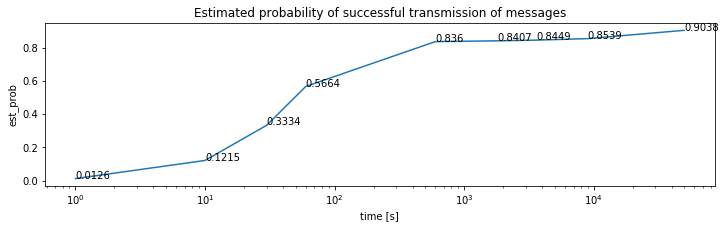

In [7]:
plot_prob(probs, max_w_size)

# Evaluation on LSTM predictions

Applying the same procedure to the predicted future values of LSTM network output, we should get *estimation* of probability of successful transmission of LoRa messages from end device to base station.

In [4]:
max_w_size = [1, 10, 30, 60, 600, 1800, 3600, 9000, 50000]
y_test_pred_10 = np.load(os.path.join(PROJ_ROOT, 'data/externals', 'y_test_pred_10.npy'))

probs = []
for w in max_w_size:
    probs.append(estimate_prob(y_test_pred_10, window_size=w))
    
plot_prob(probs, max_w_size)

KeyboardInterrupt: 

# Probability distribution for the same element of the original data

In [25]:
data_test = df[-5824584:].copy()

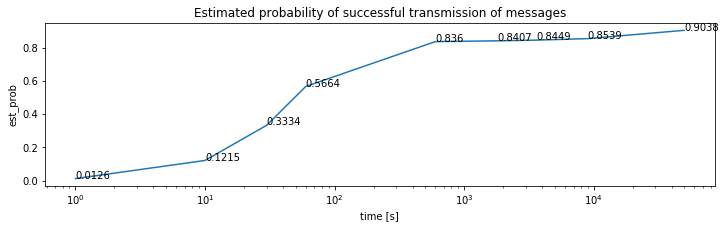

In [27]:
max_w_size = [1, 10, 30, 60, 600, 1800, 3600, 9000, 50000]

probs_test_data = []
for w in max_w_size:
    probs_test_data.append(estimate_prob(data_test.Active, window_size=w))
 
plot_prob(probs, max_w_size)